In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import add_funcs as afc
import scipy.integrate as integrate
from tqdm import tqdm

## User Inputs

In [2]:
#Set constants of interest
wl_min, wl_max = 8200, 9100 # The wavelength limits of the grid we are interested in. Preferably the same as in notebook 001
wl_left1, wl_right1 = 8200, 8300 # Give a wl range to the left of the line profile that is 'flat'. Will be used to remove surrounding continuum. Preferably ~100 Å wide at least
wl_left2, wl_right2 = 9000, 9100 # Same as above, but now to the right of the line profile


CaNARY_lib_path = os.getcwd() + '/profile_library/' # The path to the CaNARY simulated spectra library
line_profile_fnames = os.listdir(CaNARY_lib_path) # The names of all line profiles in the CaNARY library

save_fname = 'CaNARY_results.txt' # File to store our fitting results


desired_line_wl = 8727 # Give the exact wl of the line for which you want to know its contribution to the profile. Use exact same format as in notebook 001

autopilot = False # If True, the program will perform all fits without any constraints. Use only if you want to get a quick look at a big sample
chi2_threshold = 2 # The normalised threshold considered as the 1 sigma uncertainty range for P_CI (best fit is always set to chi2 = 1)

In [3]:
# Provide information about the spectra you want to be fitted

epoch_list = [295] # Provide a list of epochs [d] post explosion for your spectra. Sorted same as in fname_list!
fname_list = ['example_spectrum.csv'] # Provide the paths to your spectra. The files are assumed to be of a Nx2 structure, with wl in Å in col 0, flux in col 1. Assumed to be located in the folder '/spectra_to_be_fitted/'



## Code start
The code starts working below, you should not have to change anything here!

Before starting, check if you are not overwriting an existing fits file.
                     If all looks good, answer [y]y


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Current index is:  0
Below we plot spectrum:  example_spectrum.csv


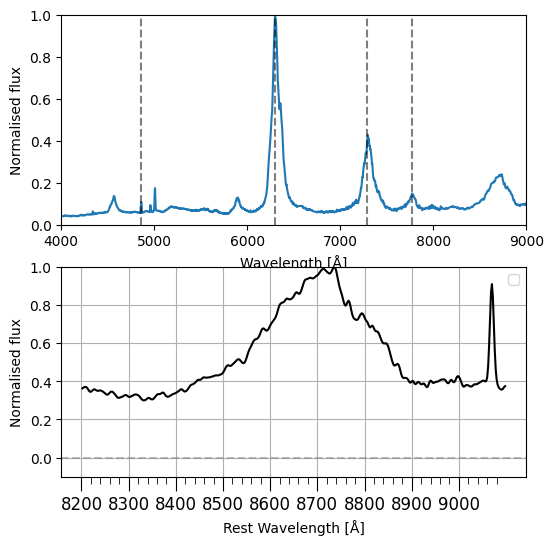

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The data has now been rebinned and a flat continuum has been removed in the region of interest:


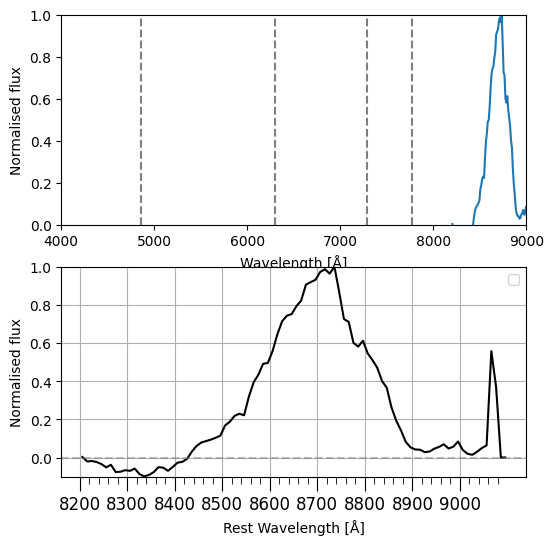

Here you can constrain v_out. Below are fits of a few spectral lines,
          and their respective velocity estimates. Based on this, write a velocity range
          in the format [xxxx,xxxx] (NOTE: the maximum range is [3000,7000])


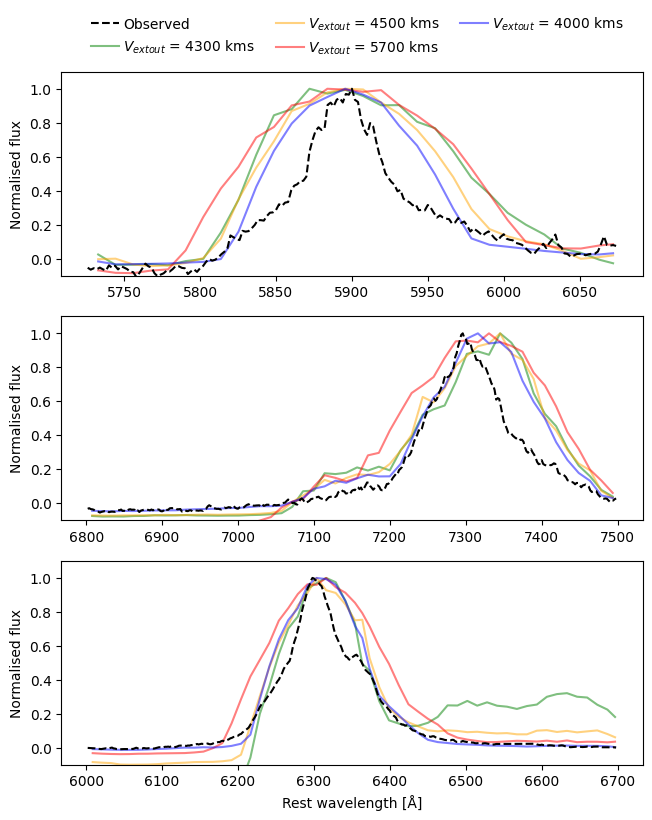

[3500,6001]
Finally, give the wavelength bounds of where the line complex starts and ends (i.e. differ from continuum)
Be as specific as possible! Answer in the format [xxxx,xxxx]
[8420,8900]
Thank you. We now start the fitting process!
The fitting for spectrum example_spectrum.csv  has been completed!
The best score is:  0.2965225130233313
Below we plot the best fit for  example_spectrum.csv
We fitted  81  out of  108  profiles.
The best score per datapoint was:  0.003
This profile had the following parameters:


v_out: 6000 km/s
Line 1: 8446.0 Å, tau = 1.00e-10, normalised luminosity: 0.0% 
Line 2: 8498.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 3: 8542.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 4: 8662.0 Å, tau = 1.00e+10, normalised luminosity: 10.0% 
Line 5: 8727.0 Å, tau = 1.00e-10, normalised luminosity: 70.0% 
Line 6: 8806.0 Å, tau = 0.00e+00, normalised luminosity: 0.0% 


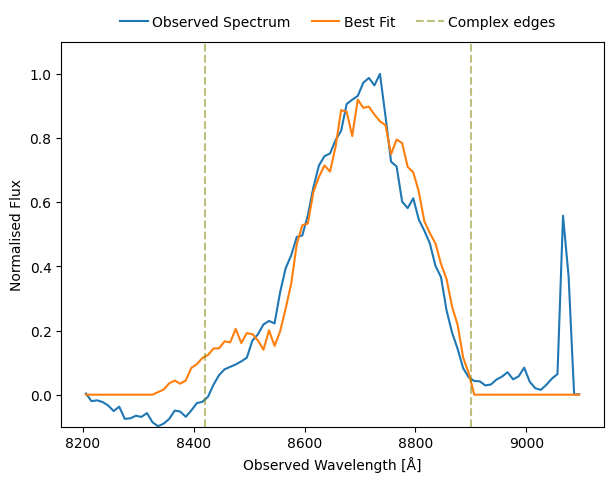

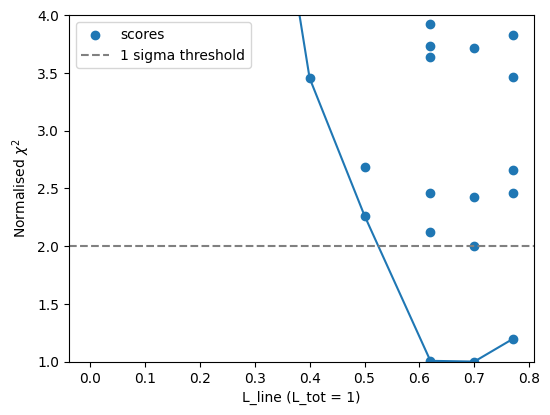

In the plot above, the best fit L_line is:  0.70
The uncertainty range is:  0.53  to  1.00


In [4]:
# The Main program: find the best luminosity fit for the line of interest for all provided SNe spectra.

start_index = 0 #The index in 'spectra_list' from where to start fitting, in case we have to interrupt the fitting prematurely
current_index = 0 # 

safety_check = input("""Before starting, check if you are not overwriting an existing fits file.
                     If all looks good, answer [y]""")
if safety_check != 'y':
    sys.exit()
#==========================================================================================================
# Some further initialisation...
    
spectra_list = [] # We now read in the provided spectra fnames
for i in range(len(fname_list)):
    spectra_list.append(np.loadtxt('spectra_to_be_fitted/' + fname_list[i], delimiter = ','))
    
#==========================================================================================================
    

for i in range(len(spectra_list)): # For each SN spectrum to be fitted...
    
    #==========================================================================================================
    # In this section we read in the spectra

    print('Current index is: ', current_index) 
    if current_index < start_index: # Little trick to start where we stopped last time
        current_index += 1
        continue
    
    # Open the spectrum
    this_spectrum = spectra_list[i]
    this_epoch = epoch_list[i]
    this_fname = fname_list[i]
    
    # Assign wl+flux and remove NANS
    wl, flux = this_spectrum[:, 0], this_spectrum[:, 1]
    wl, flux = wl[flux > -np.inf], flux[flux > -np.inf] #This step removes any NANs in the spectra
    
    print('Below we plot spectrum: ', this_fname)
    
    afc.plot_individual_spectrum(wl, flux, wl_min, wl_max)
    #==========================================================================================================
    
    #==========================================================================================================
    # Now we perform some data preprocessing steps and plot again
    
    wl_zoom, flux_zoom = wl[(wl_min < wl) * (wl_max > wl)], flux[(wl_min < wl) * (wl_max > wl)] # Zoom in
    
    processed_wl, flux_binned = afc.rebin_spectrum(wl_zoom, flux_zoom) # This rebins each spectrum to bins of rouhgly 10 Å
    
    processed_flux, total_line_profile_flux = afc.remove_continuum_flux(processed_wl, flux_binned, wl_left1, wl_right1, wl_left2, wl_right2) # Remove a flat continuum
     
    print('The data has now been rebinned and a flat continuum has been removed in the region of interest:')
        
    afc.plot_individual_spectrum(processed_wl, processed_flux, wl_min, wl_max) # Plot the spectrum after the processing steps
    
    #==========================================================================================================
    
    #==========================================================================================================
    # Lets obtain the constraints used to select the subsample of the line profile library to compare to
    
    if autopilot == False:
        constraints_list = afc.constrain_parameter_space(wl, flux, this_epoch) # Obtain the constraints from the user. Use the old wl, flux to be able to plot the entire spectrum
    
    elif autopilot == True:
        constraints_list = [[3000,7001], [wl_min,wl_max]] # Put no constraints, fit to all simulated line profiles. First list is v_out bounds, second wl range part of the profile itself

    #==========================================================================================================
    
    #==========================================================================================================
    # Start comparing to the subset of line profiles from the library
    score_list, n_valid = [], 0 # Initialise

    for j in range(len(line_profile_fnames)): # Start the fitting process. For each existing profile in library...
            
        valid = afc.check_constraints(constraints_list, line_profile_fnames[j]) # Check if this profile is within the provided constraints

        if valid: # If this profile is taken into consideration...
            n_valid += 1

            simulated_profile = np.loadtxt(CaNARY_lib_path + line_profile_fnames[j], delimiter = ',') # Load in the simulated profile
            simulated_wl, simulated_flux = simulated_profile[:, 0], simulated_profile[:, 1] 
            
            line_complex_bounds = constraints_list[1] # The wl region considered when determining the chi2 score
            this_score = afc.calculate_score(processed_wl, processed_flux, simulated_wl, simulated_flux, line_complex_bounds) # Determine fit quality
            
            
            score_list.append(this_score)
            
        else: # If this profile should be skipped
            this_score = np.inf # No score defined
            score_list.append(this_score) # Append a score anyways to assure correct indexing in future
   
    # Get the best scoring profile and plot it
    print('============================================================')
    print('The fitting for spectrum', this_fname, ' has been completed!')
    print('The best score is: ', min(score_list))
    print('Below we plot the best fit for ', this_fname)
    print('We fitted ', n_valid, ' out of ', len(line_profile_fnames), ' profiles.')

    score_per_datapoint = np.min(score_list)/len(processed_wl)
    print('The best score per datapoint was: ', '{0:.3f}'.format(score_per_datapoint))
    
    afc.plot_best_fit(score_list, processed_wl, processed_flux, line_complex_bounds, CaNARY_lib_path, line_profile_fnames)
    
    # Get the lower and upper 1 sigma bounds and plot the chi2 scores vs P_CI
    best_line_lum, left_line_lum_bound, right_line_lum_bound = afc.plot_chi2_scores(score_list, line_profile_fnames, desired_line_wl, chi2_threshold)
    #==========================================================================================================

    #==========================================================================================================
    # Finally store the output
    afc.write_output(this_fname, this_epoch, total_line_profile_flux, best_line_lum,
                 left_line_lum_bound, right_line_lum_bound, score_per_datapoint, save_fname)
    
    #==========================================================================================================
    
    current_index += 1 # Don't forget to increase the current_index